# Load Modules

In [1]:
# twitter api
# import tweepy

# natural language processing
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# json
import json
import os

# Google Cloud
# from google.cloud import language, storage

# Formatting
from pprint import pprint

# Datetime Manipulation
import datetime
import pytz
from pytz import timezone

# Linear Algebra
import pandas as pd
import numpy as np
from IPython.display import display

# Visulizations
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.dashboard_objs as dashboard
import seaborn as sns
sns.set_style("white")
colors = sns.color_palette()

#Geotagging
import geopy
from geopy import geocoders
from geopy.geocoders import Nominatim

import re

# Load Data

The first thing we'll have to do is compile the data from our twitter scraper. This script will iterate through each csv and concatenate it to our tweet dataframe.

In [2]:
state_code = json.load(open('data/state_codes.json', 'r'))
plotly_auth = json.load(open('data/plotly_auth.json', 'r'))
twitter_auth = json.load(open('data/twitter_auth.json', 'r'))
google_auth = json.load(open('data/google_auth.json', 'r'))

In [3]:
tweet_df = pd.DataFrame(
    columns=['user', 
             'sentiment_score', 
             'sentiment_magnitude',
             'full_text',
             'time_stamp',
             'location'
            ])
month = 11
for day in range(13,23):
    for hour in range(24):
        try:
            cur_tweets = pd.read_csv('data/tweets/tweets_{0}_{1}_{2}.csv'.format(month, day, hour))
            tweet_df = tweet_df.append(cur_tweets, ignore_index=True)
        except:
            pass
         

# Authorization

In [22]:
# Google Language API
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "data/google_auth.json"

# Google Geotag API
google_geo_auth = google_auth['geo_api_key']

# Plotly Authorization
plotly.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])

# Twitter API
CONSUMER_KEY = twitter_auth['consumer_key']
CONSUMER_SECRET = twitter_auth['consumer_secret']
ACCESS_TOKEN = twitter_auth['access_token']
ACCESS_TOKEN_SECRET = twitter_auth['access_token_secret']

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

# Structure

In [4]:
tweet_df.shape

(2030, 6)

In [5]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 6 columns):
full_text              2030 non-null object
location               2027 non-null object
sentiment_magnitude    2030 non-null float64
sentiment_score        2030 non-null float64
time_stamp             2030 non-null object
user                   2030 non-null object
dtypes: float64(2), object(4)
memory usage: 95.2+ KB


In [6]:
tweet_df.describe()

,sentiment_magnitude,sentiment_score
count,2030.000000,2030.000000
mean,0.568424,-0.038768
std,0.455797,0.294787
min,0.000000,-0.900000
25%,0.300000,-0.200000
50%,0.400000,0.000000
75%,0.800000,0.100000
max,4.400000,0.900000


In [7]:
tweet_df.describe(include=['O'])

,full_text,location,time_stamp,user
count,2030,2027,2030,2030
unique,998,1293,1945,1930
top,Anthony Weiner is in prison. Bill Clinton was ...,United States,2017-11-17 04:12:25,THR
freq,406,74,7,6


# Data Cleaning

## Reorder Columns

It's a minor detail, but will help make manipulating the dataset easier.

In [8]:
cols = list(tweet_df.columns)
cols_reordered = cols[::-1]
cols_reordered = cols_reordered[:1]+cols_reordered[2:]+cols_reordered[1:2]
cols_reordered
tweet_df = tweet_df[cols_reordered]

## Convert Datatypes

In [9]:
tweet_df['time_stamp'] = pd.to_datetime(tweet_df.time_stamp)

In [10]:
tweet_df['location'] = tweet_df['location'].str.decode('ascii', errors='ignore')
tweet_df['location'] = tweet_df['location'].str.encode('utf-8', errors='ignore')
tweet_df['location'] = tweet_df['location'].str.rstrip()
tweet_df['location'] = tweet_df['location'].str.lstrip()
tweet_df.loc[tweet_df.location == 'Hollywood South', 'location'] = 'Hollywood, CA'

To save time and avoid abusing the geocode lookup, we'll load from a csv until the we have all the twitter data.

In [11]:
# temp_df = pd.read_csv('data/tweets_total.csv')
# tweet_df['address'] = temp_df.address
# tweet_df['state'] = temp_df.state

In [12]:
for i in range(10,20):
    full_name = re.findall(r"full_name=u'(.+?)', ", tweet_df.loc[i,'location'])[0]
    tweet_df.loc[i,'location'] = full_name

In [13]:
tweet_df['address'] = None
tweet_df['state'] = None
tweet_df['geocode'] = None

In [14]:
tweet_df.head()

,user,sentiment_score,sentiment_magnitude,location,full_text,time_stamp,address,state,geocode
0,jtrev492,-0.5,0.5,Shadow Moses Island,I realized that Louis C.K sex/masturbation jok...,2017-11-13 00:35:00,None,None,None
1,neovve,-0.4,0.4,"New York, USA","""Louis C.K. and Hollywood’s Canon of Creeps"" b...",2017-11-13 00:34:42,None,None,None
2,Vexyvox,-0.4,0.4,NaN,"""Louis C.K. and Hollywood’s Canon of Creeps"" h...",2017-11-13 00:34:39,None,None,None
3,love_umei,-0.2,0.2,China,Louis C.K. and Hollywood’s Canon of Creeps By ...,2017-11-13 00:34:38,None,None,None
4,ColdCoffee_x,0.0,0.1,Chile,Louis C.K. breaks silence: 'These stories are ...,2017-11-13 00:34:38,None,None,None


In [61]:
geolocator = geocoders.GoogleV3(timeout=60)
tweet_df.loc[1, 'geocode'] = geolocator.geocode(tweet_df.loc[1, 'location']).address

In [33]:
geolocator.geocode(tweet_df.loc[1, 'location'])

Location((40.7127753, -74.0059728, 0.0))

In [36]:
tweet_df.describe(include=['O'])

,user,location,full_text,address,geocode
count,2030,2027,2030,2030,2029
unique,1930,1276,998,1,1
top,THR,United States,Anthony Weiner is in prison. Bill Clinton was ...,NaN,NaN
freq,6,74,406,2030,2029


In [64]:
len(tweet_df[tweet_df.geocode != 'NaN'])

127

In [20]:
tweet_df.head()

,user,sentiment_score,sentiment_magnitude,location,full_text,time_stamp,address,state,geocode
0,jtrev492,-0.5,0.5,Shadow Moses Island,I realized that Louis C.K sex/masturbation jok...,2017-11-13 00:35:00,None,None,None
1,neovve,-0.4,0.4,"New York, USA","""Louis C.K. and Hollywood’s Canon of Creeps"" b...",2017-11-13 00:34:42,"New York, NY, USA",None,None
2,Vexyvox,-0.4,0.4,NaN,"""Louis C.K. and Hollywood’s Canon of Creeps"" h...",2017-11-13 00:34:39,None,None,None
3,love_umei,-0.2,0.2,China,Louis C.K. and Hollywood’s Canon of Creeps By ...,2017-11-13 00:34:38,None,None,None
4,ColdCoffee_x,0.0,0.1,Chile,Louis C.K. breaks silence: 'These stories are ...,2017-11-13 00:34:38,None,None,None


In [15]:
geolocator = geocoders.GoogleV3(timeout=60)
for i in range(50):
    geocode = geolocator.geocode(tweet_df.loc[i, 'location'])
    if geocode:
        tweet_df.loc[i, 'address'] = geocode.address

GeocoderQuotaExceeded: The given key has gone over the requests limit in the 24 hour period or has submitted too many requests in too short a period of time.

In [ ]:
geolocator = geocoders.DataBC(timeout=60)
for i in range(400,800):
    tweet_df.loc[i, 'geocode'] = geolocator.geocode(tweet_df.loc[i, 'location']).address

In [ ]:
geolocator = geocoders.DataBC(timeout=60)
for i in range(800,1200):
    tweet_df.loc[i, 'geocode'] = geolocator.geocode(tweet_df.loc[i, 'location']).address

In [ ]:
geolocator = geocoders.DataBC(timeout=60)
for i in range(1200,1600):
    tweet_df.loc[i, 'geocode'] = geolocator.geocode(tweet_df.loc[i, 'location']).address

In [ ]:
geolocator = geocoders.DataBC(timeout=60)
for i in range(1600,2000):
    tweet_df.loc[i, 'geocode'] = geolocator.geocode(tweet_df.loc[i, 'location']).address

In [39]:
dir(geocoders)

['ArcGIS',
 'Baidu',
 'Bing',
 'DataBC',
 'GeoNames',
 'GeocodeFarm',
 'GeocoderDotUS',
 'GeocoderNotFound',
 'GoogleV3',
 'IGNFrance',
 'LiveAddress',
 'NaviData',
 'Nominatim',
 'OpenCage',
 'OpenMapQuest',
 'Photon',
 'SERVICE_TO_GEOCODER',
 'What3Words',
 'YahooPlaceFinder',
 'Yandex',
 '__all__',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 'arcgis',
 'baidu',
 'base',
 'bing',
 'databc',
 'dot_us',
 'geocodefarm',
 'geonames',
 'get_geocoder_for_service',
 'googlev3',
 'ignfrance',
 'navidata',
 'opencage',
 'openmapquest',
 'osm',
 'photon',
 'placefinder',
 'smartystreets',
 'what3words',
 'yandex']

In [12]:
geolocator = geocoders.Nominatim(timeout=60)
tweet_df['geocode'] = tweet_df.location.apply(geolocator.geocode)

GeocoderServiceError: HTTP Error 429: Too Many Requests

In [13]:
len(tweet_df)

2030

In [14]:
tweet_df['address'] = None
for i in range(len(tweet_df)):
    if tweet_df.loc[i, 'geocode'] != None:
        tweet_df.loc[i, 'address'] = tweet_df.loc[i, 'geocode'].address

KeyError: 'the label [geocode] is not in the [index]'

In [ ]:
tweet_df['state'] = None
for i in range(len(tweet_df)):
    if tweet_df.loc[i, 'address'] != None and tweet_df.loc[i, 'address'].split()[-1] == 'America' and tweet_df.loc[i, 'address'].split()[0] != 'United':
        address_split = tweet_df.loc[i, 'address'].split(', ')
        address_split_words = [address for address in address_split if re.match(r'[A-Za-z ]+', address)]
        tweet_df.loc[i, 'state'] = address_split_words[-2]       

In [ ]:
tweet_df.to_csv('data/tweets_total.csv', encoding='utf-8')

# Visualizations

I'll definitely have to come back to the data cleaning stage, but I need to create some visualizations first to get a better understanding of the data.

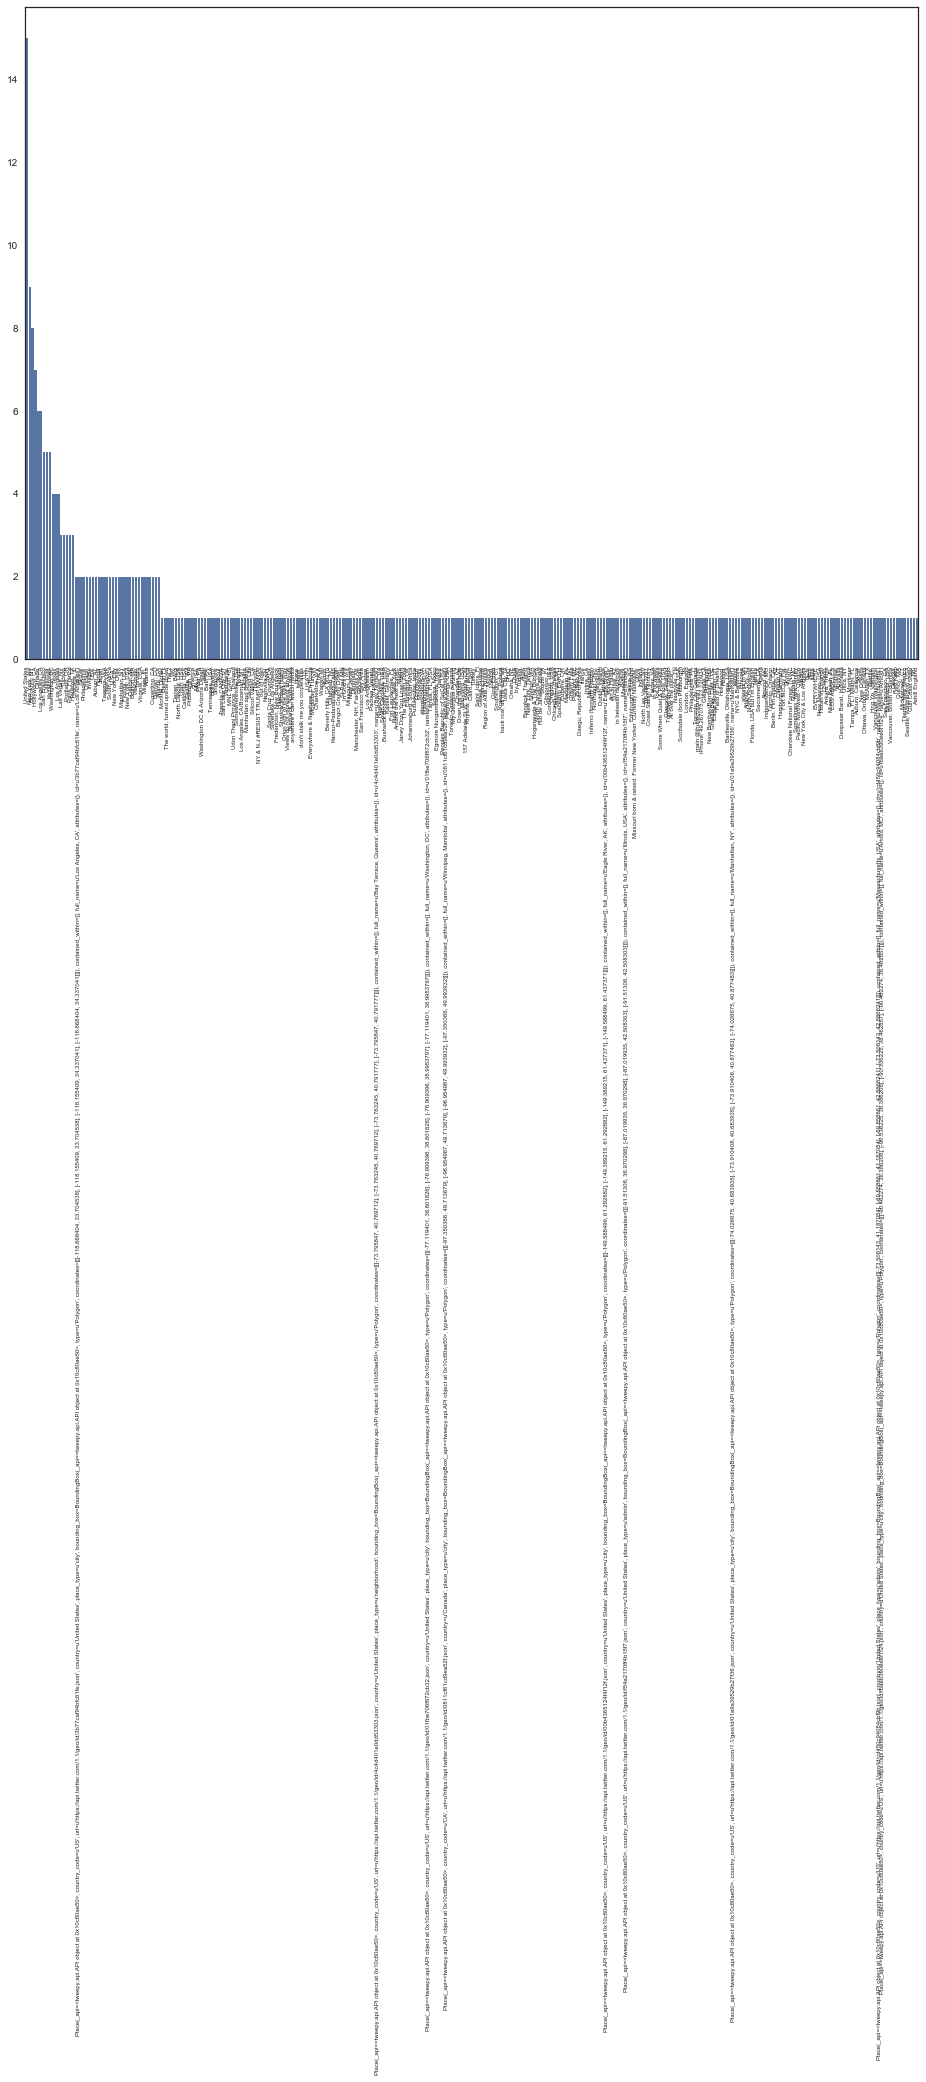

In [17]:
locations = tweet_df.location.value_counts()
locations.values

plt.figure(figsize=(16,12))
sns.barplot(x=locations.index, y=locations.values, color=colors[0])
plt.xticks(rotation=90)
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontsize(6)
    #label.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.65 ))
    #label.set_zorder(20)
plt.show()

# Dashboard Visualizations

## Choropleth

In [18]:
tweet_df['state'] = tweet_df.state.replace('WV', 'West Virginia')
total_tweets_by_state = tweet_df.state.value_counts()
total_tweets_by_state = total_tweets_by_state.reset_index()
total_tweets_by_state = total_tweets_by_state.rename(columns={'index': 'state', 'state':'tweets'})
total_tweets_by_state['state_code'] = total_tweets_by_state.state.map(state_code)

In [19]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = 'Viridis',
        autocolorscale = False,
        locations = total_tweets_by_state['state_code'],
        z = total_tweets_by_state['tweets'].astype(int),
        locationmode = 'USA-states',
        text = total_tweets_by_state['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Tweets")
        ) ]

layout = dict(
        title = 'Total Tweets About Louis C.K. <br>(Hover for details)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig, filename='louis-ck-totals-choropleth-map' )

In [20]:
tweet_avg = tweet_df.groupby('state').mean()
tweet_avg.reset_index(inplace=True)
tweet_avg['tweets'] = tweet_df.groupby('state').count().reset_index()['user']
tweet_avg['tweets'] = tweet_avg['tweets'].astype(str)
#tweet_avg['sentiment_magnitude'] = tweet_avg['sentiment_magnitude'].astype(str)
tweet_avg['state_code'] = tweet_avg['state'].map(state_code)
tweet_avg['text'] = tweet_avg['state'] + '<br>' + 'Tweets: ' + tweet_avg['tweets']

[array([ 0.25199714,  0.49873371,  0.57516028,  1.        ]),
 array([ 0.43026136,  0.62000665,  0.67878019,  1.        ]),
 array([ 0.60852558,  0.74127959,  0.7824001 ,  1.        ]),
 array([ 0.7867898 ,  0.86255253,  0.88602001,  1.        ]),
 array([ 0.95,  0.95,  0.95,  1.  ]),
 array([ 0.95457726,  0.76653099,  0.78032569,  1.        ]),
 array([ 0.91971827,  0.58735877,  0.61174   ,  1.        ]),
 array([ 0.88485928,  0.40818655,  0.44315432,  1.        ]),
 array([ 0.85104086,  0.23436275,  0.27960104,  1.        ])]

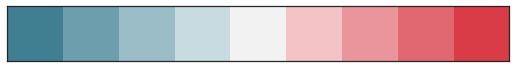

In [21]:
sns.choose_diverging_palette()

In [22]:
orbu_cmap = sns.diverging_palette(20, 240, s=99, n=200, as_cmap=True)
rdgn_cmap = sns.diverging_palette(10, 130, s=99, l=32, n=200, as_cmap=True)

norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

def matplotlib_to_plotly(cmap, pl_entries=255):    
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

rdylgn = matplotlib_to_plotly(matplotlib.cm.get_cmap('RdYlGn'))
rdbu = matplotlib_to_plotly(matplotlib.cm.get_cmap('RdBu'))
orbu = matplotlib_to_plotly(sns.diverging_palette(20, 240, s=99, n=200, as_cmap=True))
rdgn = matplotlib_to_plotly(rdgn_cmap)

In [23]:
data = [ dict(
        type='choropleth',
        colorscale = rdgn,
        autocolorscale = False,
        locations = tweet_avg['state_code'],
        z = tweet_avg['sentiment_score'],
        zmin = -1,
        zmax = 1,
        locationmode = 'USA-states',
        text = tweet_avg['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2,
            ),
            
        ),
        colorbar = dict(
            title = "Sentiment")
        ) ]

layout = dict(
        title = 'Average Sentiment Towards Louis C.K. <br>(Sentiment measured on a scale from -1 to +1)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig, filename='louis-ck-sentiment-rdgn-choropleth-map' )

In [24]:
data = [ dict(
        type='choropleth',
        colorscale = rdbu,
        autocolorscale = False,
        locations = tweet_avg['state_code'],
        z = tweet_avg['sentiment_score'],
        zmin = -1,
        zmax = 1,
        locationmode = 'USA-states',
        #hoverinfo = 'location+percent',
        text = tweet_avg['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2,
            ),
            
        ),
        colorbar = dict(
            title = "Sentiment")
        ) ]

layout = dict(
        title = 'Average Sentiment Towards Louis C.K. <br>(Sentiment measured on a scale from -1 to +1)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig, filename='louis-ck-rdbu-choropleth' )

## Time Series

In [25]:
tweet_times = tweet_df.copy()
tweet_times.index = tweet_times['time_stamp']
tweet_times = tweet_times.resample('h').mean()

In [26]:
data = [go.Scatter(x=tweet_times.index, y=tweet_times.sentiment_score)]
py.iplot(data, filename='louis-ck-timeseries')

## Sentiment By Group Pie Chart

In [27]:
tweet_df['sentiment_sign'] = 'Neutral'
tweet_df.loc[tweet_df.sentiment_score>0, 'sentiment_sign'] = 'Positive'
tweet_df.loc[tweet_df.sentiment_score<0, 'sentiment_sign'] = 'Negative'

In [28]:
sentiment_groups = tweet_df.groupby('sentiment_sign').count().user
sentiment_groups = sentiment_groups.reset_index()
sentiment_groups.rename(columns={'user': 'count'}, inplace=True)

In [29]:
sentiment_groups

,sentiment_sign,count
0,Negative,191
1,Neutral,100
2,Positive,129


In [30]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
    "data": [
        {
            "values": sentiment_groups['count'],
            "labels": sentiment_groups['sentiment_sign'],
            "marker": {
                "line": {
                    "color": "#FFFFFF",
                    "width": 2
                    },
                "colors": [
                    "rgb(178, 62, 39)",
                    "rgb(119, 123, 132)",
                    "rgb(21, 52, 140)"
                    ]
                    },
            "insidetextfont": {
                "color": "#FFFFFF"
                },
            #"domain": {"x": [0, .48]},
            "name": "Sentiment Group",
            "hoverinfo":"label+percent+name",
            "hole": .4,
            "type": "pie"
        }],
    "layout": {
            "title":"Sentiment Towards Louis C.K.",
            "annotations": [
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": "Tweets",
                    "x": 0.5,
                    "y": 0.5
                }
            ]
        }
     
}

py.iplot(fig, filename='louis_ck_donut')

# Dashboard

In [31]:
my_dboard = dashboard.Dashboard()
plotly_auth = json.load(open('data/plotly_auth.json', 'r'))
plotly.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])

In [32]:
my_dboard.get_preview()

In [33]:
box_1 = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': 'spacecadet84:21',
    'title': 'louis-ck-timeseries-for-dashboard'
}
 
box_2 = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': 'spacecadet84:9',
    'title': 'louis-ck-pie-for-dashboard'
}
 
box_3 = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': 'spacecadet84:19',
    'title': 'louis-ck-choropleth-for-dashboard'
}
 
my_dboard.insert(box_1)
my_dboard.insert(box_2, 'above', 1)
my_dboard.insert(box_3, 'left', 2)

In [34]:
py.dashboard_ops.upload(my_dboard, 'Louis CK Sentiment Dashboard')

u'https://plot.ly/~spacecadet84/23/untitled-dashboard/'